# WGAN-GP

元論文 : Improved Training of Wasserstein GANs https://arxiv.org/abs/1704.00028 (2017)

### 論文のサマリ 

WGANのパラメータのクリッピングは最適化を難しくするというのがWGAN-GPの導入背景。
Critic(DiscriminatorをWGANの論文ではCriticと呼ぶ)にBatch Normalizationが入っているとパラメータのクリッピング問題は弱めることができるけど、深いCriticでは収束しにくいらしい。

Criticのパラメータを[-c, c]にクリッピングするが、cの値を注意深く選ばないと勾配消失か勾配爆発になってしまう。しかし、WGANでWasserstain距離を用いた画像でLossを作るために1Lipschits制約を実現するために、このクリッピングが必要だった。

なので、**WGAN-GPでは勾配を1に近づける正則化項（=GP : Gradient Penalty) を導入することで、クリッピングを行わずに1Lipschits制約を実現する。**

ただし、BatchNormalizationはバッチで正規化するけど、GPは入力毎に行うので、相性が悪い。CriticではBatchNormalizationの代わりにLayerNormalizationを入れた。(これで結果も良くなった)

以上がWGAN-GPの論文での主張

DCGAN, LSGAN, WGAN, WGAN-GPを比較するために、GeneratorとDiscriminatorにいろんな条件をつけて LSUNデータセットで試した。その結果がFigure.2。WGAN-GPがずば抜けていい画像を作っている。しかもRes101をGとDに使ってもモード崩壊に陥らないという。

### アルゴリズム

WGAN-GPのアルゴリズムは、イテレーション毎に以下のDiscriminatorとGeneratorの学習を交互に行っていく。
- 最適化 : Adam (LearningRate: 0.0001, β1=0, β2=0.9)
- λ = 10

アルゴリズム

#### Discriminatorの学習(以下をcriticの回数だけ繰り返す）

1. ノイズzをサンプリングし、 $G_z = G(z)$ を求める
2. $\epsilon \in [0, 1]$ をランダムに選び、Realデータ$X$ と　$G_z$ の重み付き平均 $\hat{x} = \epsilon X + (1 - \epsilon) G_z$ を計算する
3. Loss $L^i = D(G_z) - D(X) + \lambda (\| \nabla_{\hat{x}} D(\hat{x}) \|_2 - 1)^2$　を計算し、SGD

#### Generatorの学習

1. ノイズzをサンプリングして、 Loss $L = \frac{1}{|Minibatch|} \sum_{i} - D(G(z))$ を計算し、SGD

GeneratorとDiscriminatorの構造は次の通り。WGAN-GPではResBlock構造を導入して、Deepな構造にしている。

#### Generator

ResNetの活性化関数はReLU

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

#### Discriminator

ResNetの活性化関数はLeakyReLU(0.2)

<img src='https://github.com/yoyoyo-yo/DeepLearningMugenKnock/blob/master/Scripts_Generative/assets/WGAN-gp_D.png' width=600>

それぞれにおいてResBlockは以下の構造となる

#### ResBlock

<img src='../assets/WGAN-gp_ResBlock.png' width=300>

## Import and Config

In [21]:
import torch
import torch.nn.functional as F
import torchvision
import numpy as np
from collections import OrderedDict
from easydict import EasyDict
import argparse
import os
import matplotlib.pyplot as plt
import pandas as pd
from _main_base import *

#---
# config
#---
cfg = EasyDict()

# class
cfg.CLASS_LABEL = ['akahara', 'madara'] # list, dict('label' : '[B, G, R]')
cfg.CLASS_NUM = len(cfg.CLASS_LABEL)

# model
cfg.INPUT_Z_DIM = 128
cfg.INPUT_MODE = None

cfg.OUTPUT_HEIGHT = 32
cfg.OUTPUT_WIDTH = 32
cfg.OUTPUT_CHANNEL = 3
cfg.OUTPUT_MODE = 'RGB'  # RGB, GRAY, EDGE, CLASS_LABEL

cfg.G_DIM = 64
cfg.D_DIM = 64

cfg.CHANNEL_AXIS = 1 # 1 ... [mb, c, h, w], 3 ... [mb, h, w, c]

cfg.GPU = False
cfg.DEVICE = torch.device('cuda' if cfg.GPU and torch.cuda.is_available() else 'cpu')

# train
cfg.TRAIN = EasyDict()
cfg.TRAIN.DISPAY_ITERATION_INTERVAL = 50

cfg.PREFIX = 'WGAN-GP'
cfg.TRAIN.MODEL_G_SAVE_PATH = 'models/' + cfg.PREFIX + '_G_{}.pt'
cfg.TRAIN.MODEL_D_SAVE_PATH = 'models/' + cfg.PREFIX + '_D_{}.pt'
cfg.TRAIN.MODEL_SAVE_INTERVAL = 200
cfg.TRAIN.ITERATION = 10_000
cfg.TRAIN.MINIBATCH = 32
cfg.TRAIN.OPTIMIZER_G = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_G = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.OPTIMIZER_D = torch.optim.Adam
cfg.TRAIN.LEARNING_PARAMS_D = {'lr' : 0.0001, 'betas' : (0., 0.9)}
cfg.TRAIN.LOSS_FUNCTION = None

cfg.TRAIN.DATA_PATH = './data/'
cfg.TRAIN.DATA_HORIZONTAL_FLIP = False # data augmentation : holizontal flip
cfg.TRAIN.DATA_VERTICAL_FLIP = False # data augmentation : vertical flip
cfg.TRAIN.DATA_ROTATION = False # data augmentation : rotation False, or integer

cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE = True
cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL = 500
cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'
cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH = 'result/' + cfg.PREFIX + '_loss.txt'

#---
# WGAN  config
#---
cfg.TRAIN.WGAN_CRITIC_N = 5
cfg.TRAIN.WGAN_GP_LAMBDA = 10

# test
cfg.TEST = EasyDict()
cfg.TEST.MODEL_G_PATH = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
cfg.TEST.DATA_PATH = './data'
cfg.TEST.MINIBATCH = 10
cfg.TEST.ITERATION = 2
cfg.TEST.RESULT_SAVE = False
cfg.TEST.RESULT_IMAGE_PATH = 'result/' + cfg.PREFIX + '_result_{}.jpg'

# random seed
torch.manual_seed(0)


# make model save directory
def make_dir(path):
    if '/' in path:
        model_save_dir = '/'.join(path.split('/')[:-1])
        os.makedirs(model_save_dir, exist_ok=True)

make_dir(cfg.TRAIN.MODEL_G_SAVE_PATH)
make_dir(cfg.TRAIN.MODEL_D_SAVE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH)
make_dir(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH)


## Define Model

In [22]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        x = x.view(x.size()[0], -1)
        return x

class Reshape(torch.nn.Module):
    def __init__(self, c, h, w):
        super(Reshape, self).__init__()
        self.c = c
        self.h = h
        self.w = w
    
    def forward(self, x):
        x = x.view(x.size()[0], self.c, self.h, self.w)
        return x
    
    
# ResNet block
class ResBlock(torch.nn.Module):
    def __init__(self, dim_first=None, dim=128, activation_fn=torch.nn.ReLU(), batch_norm=False, name=''):
        super(ResBlock, self).__init__()

        if dim_first is None:
            dim_first = dim
        else:
            if batch_norm:
                self.skip_conv = torch.nn.Sequential(OrderedDict({
                    name + '_skip_bn' : torch.nn.BatchNorm2d(dim_first),
                    name + '_skip_activation' : activation_fn,
                    name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                }))
            else:
                self.skip_conv = torch.nn.Sequential(OrderedDict({
                    name + '_skip_activation' : activation_fn,
                    name + '_skip_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1)
                }))
        
        if batch_norm:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_bn' : torch.nn.BatchNorm2d(dim_first),
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_bn' : torch.nn.BatchNorm2d(dim),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))
        else:
            self.block = torch.nn.Sequential(OrderedDict({
                name + '_layer_1_activation' : activation_fn,
                name + '_layer_1_conv' : torch.nn.Conv2d(dim_first, dim, kernel_size=3, padding=1, stride=1),
                name + '_layer_2_activation' : activation_fn,
                name + '_layer_2_conv' : torch.nn.Conv2d(dim, dim, kernel_size=3, padding=1, stride=1)
            }))


    def forward(self, x):
        res_x = self.block(x)

        if hasattr(self, 'skip_conv'):
            x = self.skip_conv(x)
        
        x = torch.add(res_x, x)
        x = F.relu(x)
        return x
        
    
class Generator(torch.nn.Module):

    def __init__(self):
        super(Generator, self).__init__()
        self.module = torch.nn.Sequential(OrderedDict({
            'G_layer_1' : torch.nn.Linear(cfg.INPUT_Z_DIM, cfg.G_DIM * (cfg.OUTPUT_HEIGHT // 8) * (cfg.OUTPUT_WIDTH // 8)),
            'G_layer_1_reshape' : Reshape(cfg.G_DIM, cfg.OUTPUT_HEIGHT // 8, cfg.OUTPUT_HEIGHT // 8),
            'G_layer_1_bn' : torch.nn.BatchNorm2d(cfg.G_DIM),
            'G_layer_1_activation' : torch.nn.ReLU(),     
            
            'G_layer_2_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_1'),
            'G_layer_2_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_3_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_2'),
            'G_layer_3_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
            
            'G_layer_4_resBlock' : ResBlock(dim=cfg.G_DIM, activation_fn=torch.nn.ReLU(), batch_norm=True, name='G_resBlock_3'),
            'G_layer_4_upsampling' : torch.nn.UpsamplingBilinear2d(scale_factor=2),
        
            'G_layer_out' : torch.nn.Conv2d(cfg.G_DIM, cfg.OUTPUT_CHANNEL, kernel_size=3, stride=1, padding=1),
            'G_layer_out_activation' : torch.nn.Tanh(),
        }))
        
    def forward(self, x):
        x = self.module(x)
        return x


class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()    
        self.module = torch.nn.Sequential(OrderedDict({
            'D_layer_1_resBlock' : ResBlock(dim_first=cfg.OUTPUT_CHANNEL, dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_1'),
            'D_layer_1_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_2_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_2'),
            'D_layer_2_pool' : torch.nn.AvgPool2d(2, stride=2),

            'D_layer_3_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_3'),

            'D_layer_4_resBlock' : ResBlock(dim=cfg.D_DIM, activation_fn=torch.nn.LeakyReLU(0.2), batch_norm=False, name='D_resBlock_4'),
            'D_layer_4_activation' : torch.nn.ReLU(),

            'D_layer_5_pool' : torch.nn.AdaptiveAvgPool2d((1, 1)),
            'D_layer_5_flatten' : Flatten(),
            'D_layer_out' : torch.nn.Linear(cfg.D_DIM, 1),
        }))

    def forward(self, x):
        x = self.module(x)
        return x
    
    
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('conv') != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('bn') != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0)

## Train

Files already downloaded and verified
training start
Iter:50, LossG (fake:-2635.4419), LossD:658.9548 (real:-2875.7700, fake:-2252.8018), WDistance:-622.9683, GP:35.9865
Iter:100, LossG (fake:-21538.8633), LossD:13192.1523 (real:-31716.8809, fake:-23147.2910), WDistance:-8569.5898, GP:4622.5625
Iter:150, LossG (fake:4205.1343), LossD:6769.0415 (real:-1187.2075, fake:3496.9128), WDistance:-4684.1201, GP:2084.9214
Iter:200, LossG (fake:8885.0645), LossD:6773.2373 (real:-530.2891, fake:4326.4731), WDistance:-4856.7622, GP:1916.4751
save G >> models/WGAN-GP_G_iter200.pt, D >> models/WGAN-GP_D_iter200.pt
Iter:250, LossG (fake:-3534.2141), LossD:5363.4033 (real:-4314.0298, fake:-166.5343), WDistance:-4147.4956, GP:1215.9077
Iter:300, LossG (fake:4982.3018), LossD:5186.7173 (real:374.9557, fake:3799.1294), WDistance:-3424.1736, GP:1762.5438
Iter:350, LossG (fake:292.5489), LossD:4968.5869 (real:-2661.8035, fake:1000.3134), WDistance:-3662.1167, GP:1306.4705
Iter:400, LossG (fake:-9745.4658), 

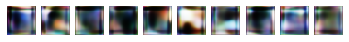

Iter:550, LossG (fake:9711.6484), LossD:6966.3833 (real:1720.9956, fake:6377.6494), WDistance:-4656.6538, GP:2309.7295
Iter:600, LossG (fake:-16815.8203), LossD:10581.8740 (real:-21939.8613, fake:-14300.4434), WDistance:-7639.4180, GP:2942.4563
save G >> models/WGAN-GP_G_iter600.pt, D >> models/WGAN-GP_D_iter600.pt
Iter:650, LossG (fake:17385.9043), LossD:7980.8394 (real:5753.3052, fake:11119.1582), WDistance:-5365.8530, GP:2614.9863
Iter:700, LossG (fake:18778.2422), LossD:8801.9531 (real:-4040.5708, fake:2274.1741), WDistance:-6314.7451, GP:2487.2078
Iter:750, LossG (fake:-18067.4512), LossD:5723.0215 (real:-16731.4492, fake:-12702.6514), WDistance:-4028.7979, GP:1694.2235
Iter:800, LossG (fake:-2422.9722), LossD:6383.8608 (real:-10731.5430, fake:-6298.9443), WDistance:-4432.5986, GP:1951.2622
save G >> models/WGAN-GP_G_iter800.pt, D >> models/WGAN-GP_D_iter800.pt
Iter:850, LossG (fake:-29706.8477), LossD:5692.0757 (real:-27897.6309, fake:-23404.9844), WDistance:-4492.6465, GP:1199.4

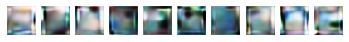

Iter:1050, LossG (fake:-7069.9189), LossD:3839.3784 (real:-6693.4507, fake:-3600.8945), WDistance:-3092.5562, GP:746.8223
Iter:1100, LossG (fake:-1618.7905), LossD:4981.2524 (real:-8338.7305, fake:-4980.3145), WDistance:-3358.4160, GP:1622.8364
Iter:1150, LossG (fake:-5927.4150), LossD:4202.3779 (real:-6316.5684, fake:-3262.4233), WDistance:-3054.1450, GP:1148.2330
Iter:1200, LossG (fake:5342.2358), LossD:4345.6455 (real:-183.8484, fake:2683.9951), WDistance:-2867.8435, GP:1477.8020
save G >> models/WGAN-GP_G_iter1200.pt, D >> models/WGAN-GP_D_iter1200.pt
Iter:1250, LossG (fake:2858.3010), LossD:5436.1899 (real:-5761.9600, fake:-2231.8030), WDistance:-3530.1570, GP:1906.0328
Iter:1300, LossG (fake:-6273.6812), LossD:3023.9202 (real:-3657.8235, fake:-1244.9574), WDistance:-2412.8662, GP:611.0539
Iter:1350, LossG (fake:6338.6821), LossD:2908.8433 (real:-1096.0345, fake:1264.0265), WDistance:-2360.0610, GP:548.7822
Iter:1400, LossG (fake:-7301.1318), LossD:4116.4341 (real:-8817.2090, fake

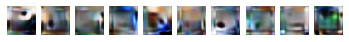

Iter:1550, LossG (fake:-3661.0107), LossD:2291.0918 (real:-5527.7754, fake:-3937.2444), WDistance:-1590.5310, GP:700.5609
Iter:1600, LossG (fake:5299.8066), LossD:3905.4548 (real:991.0004, fake:3616.2241), WDistance:-2625.2236, GP:1280.2312
save G >> models/WGAN-GP_G_iter1600.pt, D >> models/WGAN-GP_D_iter1600.pt
Iter:1650, LossG (fake:927.5926), LossD:3361.5745 (real:-17.5928, fake:2453.3652), WDistance:-2470.9580, GP:890.6165
Iter:1700, LossG (fake:-12756.6738), LossD:3476.2495 (real:-12375.8809, fake:-9720.9814), WDistance:-2654.8994, GP:821.3500
Iter:1750, LossG (fake:2722.6704), LossD:3059.6973 (real:-424.4902, fake:1818.9360), WDistance:-2243.4263, GP:816.2709
Iter:1800, LossG (fake:2283.9629), LossD:3473.8149 (real:-1061.4270, fake:1348.5018), WDistance:-2409.9287, GP:1063.8862
save G >> models/WGAN-GP_G_iter1800.pt, D >> models/WGAN-GP_D_iter1800.pt
Iter:1850, LossG (fake:-3485.0945), LossD:3146.1345 (real:-5659.7188, fake:-3539.0508), WDistance:-2120.6680, GP:1025.4666
Iter:19

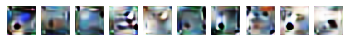

Iter:2050, LossG (fake:-653.8646), LossD:2748.4771 (real:-2117.4363, fake:-123.1407), WDistance:-1994.2955, GP:754.1816
Iter:2100, LossG (fake:-9798.0273), LossD:3644.1724 (real:-10816.4199, fake:-8231.5352), WDistance:-2584.8848, GP:1059.2877
Iter:2150, LossG (fake:-11264.4893), LossD:3662.2695 (real:-11289.2568, fake:-8655.6504), WDistance:-2633.6064, GP:1028.6631
Iter:2200, LossG (fake:-6866.4141), LossD:3066.5977 (real:-7341.9292, fake:-4918.8188), WDistance:-2423.1104, GP:643.4873
save G >> models/WGAN-GP_G_iter2200.pt, D >> models/WGAN-GP_D_iter2200.pt
Iter:2250, LossG (fake:-14333.2773), LossD:5479.3027 (real:-17426.6465, fake:-13721.4785), WDistance:-3705.1680, GP:1774.1350
Iter:2300, LossG (fake:10985.3545), LossD:2574.9006 (real:8357.9766, fake:10293.2598), WDistance:-1935.2832, GP:639.6174
Iter:2350, LossG (fake:19964.4375), LossD:7756.3442 (real:14210.6445, fake:20101.8398), WDistance:-5891.1953, GP:1865.1489
Iter:2400, LossG (fake:-8342.0078), LossD:5582.6826 (real:-11431.

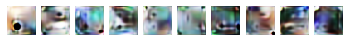

Iter:2550, LossG (fake:12273.0371), LossD:2901.1021 (real:7326.3955, fake:9328.6445), WDistance:-2002.2490, GP:898.8531
Iter:2600, LossG (fake:13165.9004), LossD:4521.2129 (real:12782.7822, fake:15994.8809), WDistance:-3212.0986, GP:1309.1143
save G >> models/WGAN-GP_G_iter2600.pt, D >> models/WGAN-GP_D_iter2600.pt
Iter:2650, LossG (fake:8650.9961), LossD:1927.4810 (real:9934.2803, fake:11049.5332), WDistance:-1115.2529, GP:812.2281
Iter:2700, LossG (fake:10099.1895), LossD:3405.9834 (real:8520.4316, fake:10939.6533), WDistance:-2419.2217, GP:986.7618
Iter:2750, LossG (fake:17343.0332), LossD:4190.3301 (real:12308.5664, fake:15535.0742), WDistance:-3226.5078, GP:963.8220
Iter:2800, LossG (fake:-1490.7241), LossD:2971.8997 (real:-718.2570, fake:1205.2744), WDistance:-1923.5314, GP:1048.3683
save G >> models/WGAN-GP_G_iter2800.pt, D >> models/WGAN-GP_D_iter2800.pt
Iter:2850, LossG (fake:28404.3730), LossD:8023.5889 (real:27013.9609, fake:32286.9961), WDistance:-5273.0352, GP:2750.5537
It

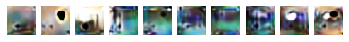

Iter:3050, LossG (fake:-14039.9668), LossD:9326.8848 (real:-23016.6992, fake:-16863.3242), WDistance:-6153.3750, GP:3173.5093
Iter:3100, LossG (fake:-8247.0146), LossD:3530.9519 (real:-4768.1455, fake:-1951.4910), WDistance:-2816.6545, GP:714.2974
Iter:3150, LossG (fake:-5428.4468), LossD:3683.3171 (real:-4762.4507, fake:-2019.6656), WDistance:-2742.7852, GP:940.5319
Iter:3200, LossG (fake:3659.6267), LossD:2326.2805 (real:974.5321, fake:2554.8528), WDistance:-1580.3207, GP:745.9598
save G >> models/WGAN-GP_G_iter3200.pt, D >> models/WGAN-GP_D_iter3200.pt
Iter:3250, LossG (fake:9345.8828), LossD:2000.5558 (real:8548.4658, fake:10154.0107), WDistance:-1605.5449, GP:395.0109
Iter:3300, LossG (fake:-14219.5762), LossD:4435.9434 (real:-15683.5010, fake:-12473.6875), WDistance:-3209.8135, GP:1226.1301
Iter:3350, LossG (fake:14761.5264), LossD:3132.4846 (real:11728.6738, fake:14064.1602), WDistance:-2335.4863, GP:796.9983
Iter:3400, LossG (fake:-365.6427), LossD:3247.4897 (real:-2305.5852, f

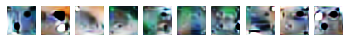

Iter:3550, LossG (fake:-8411.9189), LossD:3513.1802 (real:-7607.2188, fake:-5275.0532), WDistance:-2332.1655, GP:1181.0145
Iter:3600, LossG (fake:16964.7012), LossD:3076.5520 (real:10598.8457, fake:12739.4746), WDistance:-2140.6289, GP:935.9231
save G >> models/WGAN-GP_G_iter3600.pt, D >> models/WGAN-GP_D_iter3600.pt
Iter:3650, LossG (fake:-3458.5396), LossD:3067.5073 (real:-3963.3059, fake:-1484.9218), WDistance:-2478.3843, GP:589.1231
Iter:3700, LossG (fake:-1264.4978), LossD:2817.4927 (real:-3718.0664, fake:-1599.9343), WDistance:-2118.1321, GP:699.3605
Iter:3750, LossG (fake:20897.6895), LossD:3663.7046 (real:19986.1992, fake:22670.2773), WDistance:-2684.0781, GP:979.6265
Iter:3800, LossG (fake:9748.7617), LossD:3697.4380 (real:5839.9434, fake:8595.1699), WDistance:-2755.2266, GP:942.2115
save G >> models/WGAN-GP_G_iter3800.pt, D >> models/WGAN-GP_D_iter3800.pt
Iter:3850, LossG (fake:9260.3623), LossD:2307.8992 (real:5284.3623, fake:6912.7334), WDistance:-1628.3711, GP:679.5281
Ite

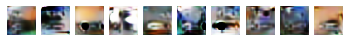

Iter:4050, LossG (fake:-6759.7603), LossD:3482.5039 (real:-7701.2397, fake:-5165.7158), WDistance:-2535.5239, GP:946.9799
Iter:4100, LossG (fake:671.4618), LossD:2371.6655 (real:375.4827, fake:2121.7444), WDistance:-1746.2617, GP:625.4039
Iter:4150, LossG (fake:7953.0020), LossD:2481.2539 (real:6503.9868, fake:8170.8545), WDistance:-1666.8677, GP:814.3862
Iter:4200, LossG (fake:-24815.0352), LossD:7471.5879 (real:-29072.6680, fake:-23368.6406), WDistance:-5704.0273, GP:1767.5604
save G >> models/WGAN-GP_G_iter4200.pt, D >> models/WGAN-GP_D_iter4200.pt
Iter:4250, LossG (fake:-10017.8994), LossD:1647.4658 (real:-10839.8398, fake:-9573.6074), WDistance:-1266.2324, GP:381.2333
Iter:4300, LossG (fake:-1107.3147), LossD:3394.8982 (real:-2818.2017, fake:-301.7730), WDistance:-2516.4287, GP:878.4695
Iter:4350, LossG (fake:-5863.1890), LossD:2265.2515 (real:-8864.6035, fake:-7473.0518), WDistance:-1391.5518, GP:873.6996
Iter:4400, LossG (fake:3395.8660), LossD:1820.5295 (real:3273.2378, fake:45

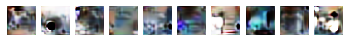

Iter:4550, LossG (fake:11853.3242), LossD:4060.3296 (real:7512.7324, fake:10516.2900), WDistance:-3003.5576, GP:1056.7721
Iter:4600, LossG (fake:3806.5916), LossD:2116.2620 (real:140.7257, fake:1621.7413), WDistance:-1481.0156, GP:635.2464
save G >> models/WGAN-GP_G_iter4600.pt, D >> models/WGAN-GP_D_iter4600.pt
Iter:4650, LossG (fake:-3710.9202), LossD:1860.9688 (real:-7336.1479, fake:-6086.2388), WDistance:-1249.9092, GP:611.0595
Iter:4700, LossG (fake:3789.6589), LossD:2201.7927 (real:2461.8821, fake:3960.9128), WDistance:-1499.0308, GP:702.7619
Iter:4750, LossG (fake:6742.5913), LossD:2143.9102 (real:2995.9368, fake:4476.2637), WDistance:-1480.3269, GP:663.5831
Iter:4800, LossG (fake:-4811.4868), LossD:2367.3538 (real:-6216.2397, fake:-4337.4795), WDistance:-1878.7603, GP:488.5935
save G >> models/WGAN-GP_G_iter4800.pt, D >> models/WGAN-GP_D_iter4800.pt
Iter:4850, LossG (fake:6194.7808), LossD:1335.7461 (real:3559.3374, fake:4435.8047), WDistance:-876.4673, GP:459.2789
Iter:4900, L

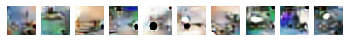

Iter:5050, LossG (fake:-15339.4219), LossD:2988.8206 (real:-16333.7480, fake:-14173.5430), WDistance:-2160.2051, GP:828.6154
Iter:5100, LossG (fake:-11933.1172), LossD:2809.7148 (real:-12713.4521, fake:-10554.1709), WDistance:-2159.2812, GP:650.4336
Iter:5150, LossG (fake:350.2244), LossD:1962.3748 (real:-183.3335, fake:1322.2004), WDistance:-1505.5339, GP:456.8408
Iter:5200, LossG (fake:-12054.4082), LossD:3298.2017 (real:-13802.7471, fake:-11447.4082), WDistance:-2355.3389, GP:942.8628
save G >> models/WGAN-GP_G_iter5200.pt, D >> models/WGAN-GP_D_iter5200.pt
Iter:5250, LossG (fake:-3771.0188), LossD:2466.2051 (real:-5861.0615, fake:-3956.6951), WDistance:-1904.3665, GP:561.8387
Iter:5300, LossG (fake:1824.1837), LossD:2197.5479 (real:10.8804, fake:1605.5521), WDistance:-1594.6718, GP:602.8760
Iter:5350, LossG (fake:6913.2734), LossD:2190.9402 (real:7401.5908, fake:8942.3242), WDistance:-1540.7334, GP:650.2068
Iter:5400, LossG (fake:15766.2598), LossD:4252.9058 (real:10513.0010, fake:

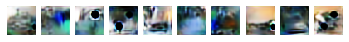

Iter:5550, LossG (fake:-11528.8145), LossD:3386.9155 (real:-12241.6582, fake:-9661.1318), WDistance:-2580.5264, GP:806.3891
Iter:5600, LossG (fake:7566.0664), LossD:2203.0298 (real:7133.1777, fake:8696.1709), WDistance:-1562.9932, GP:640.0366
save G >> models/WGAN-GP_G_iter5600.pt, D >> models/WGAN-GP_D_iter5600.pt
Iter:5650, LossG (fake:3375.7058), LossD:2743.3462 (real:1155.1566, fake:2980.6194), WDistance:-1825.4628, GP:917.8833
Iter:5700, LossG (fake:8687.1875), LossD:1728.9817 (real:7955.8164, fake:9148.5059), WDistance:-1192.6895, GP:536.2922
Iter:5750, LossG (fake:2036.9319), LossD:1908.4904 (real:-221.3145, fake:1120.4626), WDistance:-1341.7771, GP:566.7133
Iter:5800, LossG (fake:-13240.7773), LossD:2365.9233 (real:-9915.7090, fake:-8101.0518), WDistance:-1814.6572, GP:551.2662
save G >> models/WGAN-GP_G_iter5800.pt, D >> models/WGAN-GP_D_iter5800.pt
Iter:5850, LossG (fake:11236.9424), LossD:2188.1052 (real:7654.2480, fake:9195.8027), WDistance:-1541.5547, GP:646.5505
Iter:5900

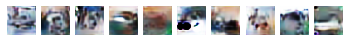

Iter:6050, LossG (fake:-3963.2368), LossD:1961.7611 (real:-6841.8979, fake:-5522.5562), WDistance:-1319.3418, GP:642.4193
Iter:6100, LossG (fake:-18052.5117), LossD:7209.0508 (real:-19156.9531, fake:-13239.4961), WDistance:-5917.4570, GP:1291.5936
Iter:6150, LossG (fake:5594.7676), LossD:1670.5084 (real:3027.4673, fake:4191.8750), WDistance:-1164.4077, GP:506.1007
Iter:6200, LossG (fake:-3079.7871), LossD:2045.3892 (real:-5073.1772, fake:-3619.9580), WDistance:-1453.2192, GP:592.1699
save G >> models/WGAN-GP_G_iter6200.pt, D >> models/WGAN-GP_D_iter6200.pt
Iter:6250, LossG (fake:-5708.5791), LossD:2307.2561 (real:-6624.8789, fake:-4917.2002), WDistance:-1707.6787, GP:599.5775
Iter:6300, LossG (fake:-10531.4951), LossD:1645.4913 (real:-10674.0908, fake:-9483.4434), WDistance:-1190.6475, GP:454.8439
Iter:6350, LossG (fake:20087.3066), LossD:4236.4653 (real:14570.3613, fake:17777.6406), WDistance:-3207.2793, GP:1029.1859
Iter:6400, LossG (fake:-14006.8086), LossD:4322.0542 (real:-12420.94

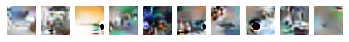

Iter:6550, LossG (fake:12948.0488), LossD:1936.4678 (real:11973.5098, fake:13135.5400), WDistance:-1162.0303, GP:774.4376
Iter:6600, LossG (fake:11854.1641), LossD:2790.5981 (real:6597.3247, fake:8618.7480), WDistance:-2021.4233, GP:769.1748
save G >> models/WGAN-GP_G_iter6600.pt, D >> models/WGAN-GP_D_iter6600.pt
Iter:6650, LossG (fake:-18243.9316), LossD:4584.6318 (real:-23313.0898, fake:-20154.8047), WDistance:-3158.2852, GP:1426.3469
Iter:6700, LossG (fake:-4273.3613), LossD:1535.4343 (real:-5532.2681, fake:-4506.5371), WDistance:-1025.7310, GP:509.7033
Iter:6750, LossG (fake:-4935.1138), LossD:1532.5718 (real:-5661.1509, fake:-4601.2637), WDistance:-1059.8872, GP:472.6846
Iter:6800, LossG (fake:-12773.7959), LossD:2736.2612 (real:-13111.2363, fake:-11115.5684), WDistance:-1995.6680, GP:740.5934
save G >> models/WGAN-GP_G_iter6800.pt, D >> models/WGAN-GP_D_iter6800.pt
Iter:6850, LossG (fake:2458.5676), LossD:2142.1597 (real:-294.4145, fake:1429.0828), WDistance:-1723.4972, GP:418.6

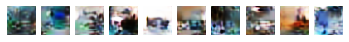

Iter:7050, LossG (fake:9342.8984), LossD:2417.1470 (real:4516.8989, fake:6202.5244), WDistance:-1685.6255, GP:731.5214
Iter:7100, LossG (fake:-11478.7539), LossD:2121.4353 (real:-12229.8545, fake:-10671.3682), WDistance:-1558.4863, GP:562.9490
Iter:7150, LossG (fake:16624.2598), LossD:4021.0000 (real:13209.6602, fake:16195.9531), WDistance:-2986.2930, GP:1034.7070
Iter:7200, LossG (fake:-4298.6650), LossD:1393.8337 (real:-2568.0835, fake:-1544.8383), WDistance:-1023.2452, GP:370.5885
save G >> models/WGAN-GP_G_iter7200.pt, D >> models/WGAN-GP_D_iter7200.pt
Iter:7250, LossG (fake:5034.4419), LossD:1910.0270 (real:3953.4382, fake:5263.9155), WDistance:-1310.4773, GP:599.5497
Iter:7300, LossG (fake:-12138.1338), LossD:1744.2898 (real:-11341.9521, fake:-9955.3799), WDistance:-1386.5723, GP:357.7176
Iter:7350, LossG (fake:-12688.5791), LossD:1561.6091 (real:-14877.4531, fake:-13836.7441), WDistance:-1040.7090, GP:520.9001
Iter:7400, LossG (fake:8640.8760), LossD:1793.7017 (real:8452.0908, f

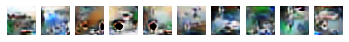

Iter:7550, LossG (fake:-37358.3398), LossD:4138.0342 (real:-36281.7812, fake:-33131.7969), WDistance:-3149.9844, GP:988.0500
Iter:7600, LossG (fake:-2684.2334), LossD:1620.9543 (real:-5364.2705, fake:-4172.2578), WDistance:-1192.0127, GP:428.9417
save G >> models/WGAN-GP_G_iter7600.pt, D >> models/WGAN-GP_D_iter7600.pt
Iter:7650, LossG (fake:-7558.3618), LossD:1456.7627 (real:-9319.1660, fake:-8291.0186), WDistance:-1028.1475, GP:428.6153
Iter:7700, LossG (fake:-2536.1206), LossD:1705.3136 (real:-3675.8613, fake:-2285.2480), WDistance:-1390.6133, GP:314.7003
Iter:7750, LossG (fake:-8882.7256), LossD:2580.7646 (real:-12008.0029, fake:-10085.1914), WDistance:-1922.8115, GP:657.9532
Iter:7800, LossG (fake:10835.9424), LossD:1498.7659 (real:5777.6309, fake:6853.3584), WDistance:-1075.7275, GP:423.0384
save G >> models/WGAN-GP_G_iter7800.pt, D >> models/WGAN-GP_D_iter7800.pt
Iter:7850, LossG (fake:-12406.8145), LossD:1727.0452 (real:-10761.4502, fake:-9481.4131), WDistance:-1280.0371, GP:44

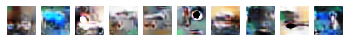

Iter:8050, LossG (fake:8996.9668), LossD:1765.4937 (real:8155.7500, fake:9347.2861), WDistance:-1191.5361, GP:573.9575
Iter:8100, LossG (fake:-12199.7637), LossD:1729.9929 (real:-13111.0557, fake:-11927.5586), WDistance:-1183.4971, GP:546.4958
Iter:8150, LossG (fake:7631.5088), LossD:1451.5273 (real:7172.3135, fake:8182.0449), WDistance:-1009.7314, GP:441.7958
Iter:8200, LossG (fake:-6107.7705), LossD:784.7117 (real:-6550.2017, fake:-6153.8721), WDistance:-396.3296, GP:388.3821
save G >> models/WGAN-GP_G_iter8200.pt, D >> models/WGAN-GP_D_iter8200.pt
Iter:8250, LossG (fake:17944.9531), LossD:2585.5771 (real:13697.1494, fake:15480.3604), WDistance:-1783.2109, GP:802.3663
Iter:8300, LossG (fake:39445.5234), LossD:2133.9314 (real:34289.9102, fake:35921.0312), WDistance:-1631.1211, GP:502.8102
Iter:8350, LossG (fake:-4429.2974), LossD:2175.4043 (real:-7180.4619, fake:-5662.1436), WDistance:-1518.3184, GP:657.0858
Iter:8400, LossG (fake:35699.8789), LossD:2728.1714 (real:30983.8633, fake:33

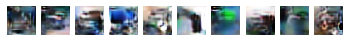

Iter:8550, LossG (fake:-2477.0657), LossD:1581.6670 (real:-2509.9717, fake:-1401.0740), WDistance:-1108.8977, GP:472.7693
Iter:8600, LossG (fake:-745.6965), LossD:1069.8595 (real:-2156.8652, fake:-1435.7351), WDistance:-721.1301, GP:348.7294
save G >> models/WGAN-GP_G_iter8600.pt, D >> models/WGAN-GP_D_iter8600.pt
Iter:8650, LossG (fake:14051.9287), LossD:2286.4272 (real:13055.4395, fake:14883.2217), WDistance:-1827.7822, GP:458.6450
Iter:8700, LossG (fake:1826.6180), LossD:1238.0868 (real:1834.3860, fake:2614.6018), WDistance:-780.2158, GP:457.8709
Iter:8750, LossG (fake:-4321.4937), LossD:1732.2988 (real:-4563.0112, fake:-3409.9512), WDistance:-1153.0601, GP:579.2388
Iter:8800, LossG (fake:-13580.4824), LossD:1831.6643 (real:-14719.2705, fake:-13439.1641), WDistance:-1280.1064, GP:551.5579
save G >> models/WGAN-GP_G_iter8800.pt, D >> models/WGAN-GP_D_iter8800.pt
Iter:8850, LossG (fake:7772.2900), LossD:1292.3787 (real:6526.7305, fake:7396.4878), WDistance:-869.7573, GP:422.6213
Iter:

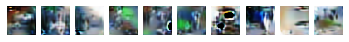

Iter:9050, LossG (fake:-2473.2297), LossD:695.5748 (real:-4449.9678, fake:-4131.5615), WDistance:-318.4062, GP:377.1686
Iter:9100, LossG (fake:-2375.0972), LossD:1173.4358 (real:-3045.7043, fake:-2338.2158), WDistance:-707.4885, GP:465.9473
Iter:9150, LossG (fake:8824.4326), LossD:1704.1954 (real:9041.6035, fake:10356.1650), WDistance:-1314.5615, GP:389.6339
Iter:9200, LossG (fake:11619.4131), LossD:941.5304 (real:9254.1611, fake:9874.1777), WDistance:-620.0166, GP:321.5138
save G >> models/WGAN-GP_G_iter9200.pt, D >> models/WGAN-GP_D_iter9200.pt
Iter:9250, LossG (fake:31514.7461), LossD:2135.2473 (real:28409.5625, fake:30004.7871), WDistance:-1595.2246, GP:540.0228
Iter:9300, LossG (fake:10572.6074), LossD:1065.8180 (real:10424.8506, fake:11283.1650), WDistance:-858.3145, GP:207.5035
Iter:9350, LossG (fake:1426.1759), LossD:1094.3516 (real:1456.3403, fake:2198.9980), WDistance:-742.6577, GP:351.6939
Iter:9400, LossG (fake:6559.4072), LossD:1286.9763 (real:4113.4478, fake:5085.2930), W

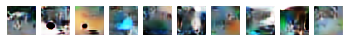

Iter:9550, LossG (fake:-7933.4297), LossD:922.0510 (real:-4007.0981, fake:-3307.8264), WDistance:-699.2717, GP:222.7792
Iter:9600, LossG (fake:2663.6846), LossD:1613.3368 (real:1492.4850, fake:2739.4917), WDistance:-1247.0067, GP:366.3301
save G >> models/WGAN-GP_G_iter9600.pt, D >> models/WGAN-GP_D_iter9600.pt
Iter:9650, LossG (fake:17871.5195), LossD:1273.0881 (real:16283.1865, fake:17059.6855), WDistance:-776.4990, GP:496.5891
Iter:9700, LossG (fake:12244.7178), LossD:2915.7649 (real:6638.8022, fake:8911.3652), WDistance:-2272.5630, GP:643.2018
Iter:9750, LossG (fake:3343.4478), LossD:1273.1936 (real:5869.2437, fake:6871.3965), WDistance:-1002.1528, GP:271.0407
Iter:9800, LossG (fake:-4626.2598), LossD:1281.0927 (real:-2592.6445, fake:-1572.3730), WDistance:-1020.2715, GP:260.8212
save G >> models/WGAN-GP_G_iter9800.pt, D >> models/WGAN-GP_D_iter9800.pt
Iter:9850, LossG (fake:11731.7959), LossD:1570.0950 (real:9436.7520, fake:10609.7979), WDistance:-1173.0459, GP:397.0491
Iter:9900,

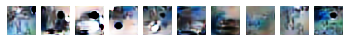

final paramters were saved to G >> models/WGAN-GP_G_final.pt, D >> models/WGAN-GP_D_final.pt
loss was saved to >> result/WGAN-GP_loss.txt


In [23]:
def result_show(G, z, path=None, save=False, show=False):
    if (save or show) is False:
        print('argument save >> {} and show >> {}, so skip')
        return

    Gz = G(z)
    Gz = Gz.detach().cpu().numpy()

    Gz = (Gz * 127.5 + 127.5).astype(np.uint8)
    Gz = Gz.reshape([-1, cfg.OUTPUT_CHANNEL, cfg.OUTPUT_HEIGHT, cfg.OUTPUT_WIDTH])
    Gz = Gz.transpose(0, 2, 3, 1)

    for i in range(cfg.TEST.MINIBATCH):
        _G = Gz[i]
        plt.subplot(1, cfg.TEST.MINIBATCH, i + 1)
        plt.imshow(_G)
        plt.axis('off')

    if path is not None:
        plt.savefig(path)
        print('result was saved to >> {}'.format(path))

    if show:
        plt.show()

# train
def train():
    # model
    G = Generator().to(cfg.DEVICE)
    D = Discriminator().to(cfg.DEVICE)
    
    G.apply(weights_init)
    D.apply(weights_init)

    opt_G = cfg.TRAIN.OPTIMIZER_G(G.parameters(), **cfg.TRAIN.LEARNING_PARAMS_G)
    opt_D = cfg.TRAIN.OPTIMIZER_D(D.parameters(), **cfg.TRAIN.LEARNING_PARAMS_D)

    #path_dict = data_load(cfg)
    #paths = path_dict['paths']
    #paths_gt = path_dict['paths_gt']

    trainset = torchvision.datasets.CIFAR10(root=cfg.TRAIN.DATA_PATH , train=True, download=True, transform=None)
    train_Xs = trainset.data
    train_ys = trainset.targets

    # training
    mbi = 0
    train_N = len(train_Xs)
    train_ind = np.arange(train_N)
    np.random.seed(0)
    np.random.shuffle(train_ind)

    list_iter = []
    list_loss_G = []
    list_loss_D = []
    list_loss_D_real = []
    list_loss_D_fake = []
    list_loss_WDistance = []
    list_loss_GP = []

    one = torch.FloatTensor([1])
    minus_one = one * -1

    print('training start')
    progres_bar = ''
    
    for i in range(cfg.TRAIN.ITERATION):
        if mbi + cfg.TRAIN.MINIBATCH > train_N:
            mb_ind = train_ind[mbi:]
            np.random.shuffle(train_ind)
            mb_ind = np.hstack((mb_ind, train_ind[ : (cfg.TRAIN.MINIBATCH - (train_N - mbi))]))
            mbi = cfg.TRAIN.MINIBATCH - (train_N - mbi)
        else:
            mb_ind = train_ind[mbi : mbi + cfg.TRAIN.MINIBATCH]
            mbi += cfg.TRAIN.MINIBATCH

        # update D
        for _ in range(cfg.TRAIN.WGAN_CRITIC_N):
            opt_D.zero_grad()

            # sample X
            Xs = torch.tensor(preprocess(train_Xs[mb_ind], cfg, cfg.OUTPUT_MODE), dtype=torch.float).to(cfg.DEVICE)

            # sample x
            z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM))
            z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

            # forward
            Gz = G(z)
            loss_D_fake = D(Gz).mean(0).view(1)
            loss_D_real = D(Xs).mean(0).view(1)
            
            #---
            # Gradient Penalty
            #---
            # sample epsilon from [0, 1]
            epsilon = np.random.random()

            # sample x_hat 
            x_hat = (epsilon * Xs + (1 - epsilon) * Gz).requires_grad_(True)
            
            Dx_hat = D(x_hat)
            musk = torch.ones_like(Dx_hat)
            gradients = torch.autograd.grad(Dx_hat, x_hat, grad_outputs=musk, retain_graph=True, create_graph=True, allow_unused=True)[0]
            gradients = gradients.view(-1, 1)
            gradient_penalty = cfg.TRAIN.WGAN_GP_LAMBDA * ((gradients.norm(2, dim=1) - 1) ** 2).mean()
            
            # loss backward
            loss_D_real.backward(one, retain_graph=True)
            loss_D_fake.backward(minus_one, retain_graph=True)
            gradient_penalty.backward(retain_graph=True)

            loss_D = loss_D_fake - loss_D_real + gradient_penalty
            Wasserstein_distance = loss_D_real - loss_D_fake

            opt_D.step()
            

        # update G
        opt_G.zero_grad()
        z = np.random.uniform(-1, 1, size=(cfg.TRAIN.MINIBATCH, cfg.INPUT_Z_DIM))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)
        loss_G = D(G(z)).mean(0).view(1)
        loss_G.backward(one)
        opt_G.step()

        progres_bar += '|'
        print('\r' + progres_bar, end='')

        _loss_G = loss_G.item()
        _loss_D = loss_D.item()
        _loss_D_real = loss_D_real.item()
        _loss_D_fake = loss_D_fake.item()
        _Wasserstein_distance = Wasserstein_distance.item()
        _gradient_penalty = gradient_penalty.item()

        if (i + 1) % 10 == 0:
            progres_bar += str(i + 1)
            print('\r' + progres_bar, end='')

            # save process result
            if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
                list_iter.append(i + 1)
                list_loss_G.append(_loss_G)
                list_loss_D.append(_loss_D)
                list_loss_D_real.append(_loss_D_real)
                list_loss_D_fake.append(_loss_D_fake)
                list_loss_WDistance.append(_Wasserstein_distance)
                list_loss_GP.append(_gradient_penalty)
                
        # display training state
        if (i + 1) % cfg.TRAIN.DISPAY_ITERATION_INTERVAL == 0:
            print('\r' + ' ' * len(progres_bar), end='')
            print('\rIter:{}, LossG (fake:{:.4f}), LossD:{:.4f} (real:{:.4f}, fake:{:.4f}), WDistance:{:.4f}, GP:{:.4f}'.format(
                i + 1, _loss_G, _loss_D, _loss_D_real, _loss_D_fake, _Wasserstein_distance, _gradient_penalty))
            progres_bar = ''

        # save parameters
        if (cfg.TRAIN.MODEL_SAVE_INTERVAL != False) and ((i + 1) % cfg.TRAIN.MODEL_SAVE_INTERVAL == 0):
            G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('iter{}'.format(i + 1))
            D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('iter{}'.format(i + 1))
            torch.save(G.state_dict(), G_save_path)
            torch.save(D.state_dict(), D_save_path)
            print('save G >> {}, D >> {}'.format(G_save_path, D_save_path))

        # save process result
        if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE and ((i + 1) % cfg.TRAIN.LEARNING_PROCESS_RESULT_INTERVAL == 0):
            result_show(
                G, z, cfg.TRAIN.LEARNING_PROCESS_RESULT_IMAGE_PATH.format('iter' + str(i + 1)), 
                save=cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE, show=True)

    G_save_path = cfg.TRAIN.MODEL_G_SAVE_PATH.format('final')
    D_save_path = cfg.TRAIN.MODEL_D_SAVE_PATH.format('final')
    torch.save(G.state_dict(), G_save_path)
    torch.save(D.state_dict(), D_save_path)
    print('final paramters were saved to G >> {}, D >> {}'.format(G_save_path, D_save_path))

    if cfg.TRAIN.LEARNING_PROCESS_RESULT_SAVE:
        f = open(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, 'w')
        df = pd.DataFrame({'iteration' : list_iter, 'loss_G' : list_loss_G, 'loss_D' : list_loss_D, 
                            'loss_D_real' : list_loss_D_real, 'loss_D_fake' : list_loss_D_fake, 'Wasserstein_Distance' : list_loss_WDistance,
                          'GP' : list_loss_GP})
        df.to_csv(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH, index=False)
        print('loss was saved to >> {}'.format(cfg.TRAIN.LEARNING_PROCESS_RESULT_LOSS_PATH))

train()

## Test

--------------------
test function
--------------------
result was saved to >> result/WGAN-GP_result_1.jpg


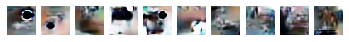

result was saved to >> result/WGAN-GP_result_2.jpg


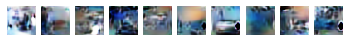

In [25]:
# test
def test():
    print('-' * 20)
    print('test function')
    print('-' * 20)
    G = Generator().to(cfg.DEVICE)
    G.load_state_dict(torch.load(cfg.TEST.MODEL_G_PATH, map_location=torch.device(cfg.DEVICE)))
    G.eval()

    np.random.seed(0)
    
    for i in range(cfg.TEST.ITERATION):
        z = np.random.uniform(-1, 1, size=(cfg.TEST.MINIBATCH, cfg.INPUT_Z_DIM))
        z = torch.tensor(z, dtype=torch.float).to(cfg.DEVICE)

        result_show(G, z, cfg.TEST.RESULT_IMAGE_PATH.format(i + 1), save=cfg.TEST.RESULT_SAVE, show=True)

test()

In [ ]:
def arg_parse():
    parser = argparse.ArgumentParser(description='CNN implemented with Keras')
    parser.add_argument('--train', dest='train', action='store_true')
    parser.add_argument('--test', dest='test', action='store_true')
    args = parser.parse_args()
    return args

# main
if __name__ == '__main__':
    args = arg_parse()

    if args.train:
        train()
    if args.test:
        test()

    if not (args.train or args.test):
        print("please select train or test flag")
        print("train: python main.py --train")
        print("test:  python main.py --test")
        print("both:  python main.py --train --test")
